In [1]:
import os
import pandas as pd
import numpy as np
import re
from scipy.stats import gmean
from scipy import stats
import matplotlib.pyplot as plt

# Sets the path to the parent directory of RR classes
data_dir = os.getcwd() + '\\Data'

In [2]:
# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv(data_dir + "\\onet_tasks.csv")
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

In [3]:
# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)

isco_list = ['ISCO' + str(i) for i in range(1,10)]
isco_data = [pd.read_excel(
       "Data\\Eurostat_employment_isco.xlsx", 
       sheet_name=isco,
       engine='openpyxl',) for isco in isco_list]

In [4]:
# Countries list
cols = isco_data[0].columns
countries = [col for col in cols if col not in ['TIME','European Union - 28 countries (2013-2020)']]
countries

['Belgium',
 'Czechia',
 'Denmark',
 'Spain',
 'Italy',
 'Lithuania',
 'Poland',
 'Finland',
 'Sweden']

In [5]:
# This will calculate worker totals in each of the chosen countries.

cols = isco_data[0].columns
countries = [col for col in cols if col not in ['TIME','European Union - 28 countries (2013-2020)']]

total = []
for country in countries:
    isco_count = 0
    result = 0
    while isco_count < len(isco_list):
        result += isco_data[isco_count][country]
        isco_count += 1
    total.append(result)

In [6]:
# Let's merge all these datasets. We'll need a column that stores the occupation categories:
i = 0
while i < len(isco_data):
    isco_data[i]['ISCO'] = i + 1
    i += 1

In [7]:
# and this gives us one large file with employment in all occupations.
all_data = pd.concat(isco_data, ignore_index=True)
all_data

,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,Sweden,ISCO
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,232.6,1
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,236.0,1
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,238.5,1
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,246.1,1
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,249.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
355,2019-Q4,19822.2,492.1,323.9,301.2,2478.6,2552.2,116.2,922.4,154.2,217.4,9
356,2020-Q1,:,447.5,313.0,286.4,2434.4,2421.7,118.2,883.4,139.9,217.5,9
357,2020-Q2,:,426.9,303.9,268.5,2163.0,2328.3,110.8,885.6,143.4,210.3,9
358,2020-Q3,:,436.1,305.9,280.1,2252.1,2512.0,110.9,887.8,153.0,218.5,9


In [8]:
i = 0
while i < len(countries):
    # We have 9 occupations and the same time range for each, so we can add the totals by
    # adding a vector that is 9 times the previously calculated totals
    all_data['total_' + total[i].name] = pd.concat([total[i]]*9, ignore_index=True)
    
    # And this will give us shares of each occupation among all workers in a period-country
    all_data['share_' + total[i].name] = all_data[total[i].name] / all_data['total_' + total[i].name]
    
    i += 1

all_data

,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,total_Italy,share_Italy,total_Lithuania,share_Lithuania,total_Poland,share_Poland,total_Finland,share_Finland,total_Sweden,share_Sweden
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,21946.6,0.040826,1201.6,0.099867,15027.1,0.064117,2348.3,0.058425,4368.4,0.053246
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,22109.7,0.040570,1222.4,0.097268,15245.5,0.060241,2447.2,0.055492,4487.7,0.052588
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,21937.7,0.038295,1229.8,0.087006,15353.6,0.059517,2448.4,0.050441,4545.6,0.052468
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,21907.1,0.034916,1231.8,0.087514,15260.8,0.061327,2392.7,0.044552,4456.6,0.055221
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,21762.2,0.035024,1218.1,0.088252,15055.5,0.063266,2366.8,0.043307,4391.9,0.056877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2019-Q4,19822.2,492.1,323.9,301.2,2478.6,2552.2,116.2,922.4,154.2,...,22462.1,0.113623,1320.8,0.087977,15851.8,0.058189,2461.1,0.062655,4904.7,0.044325
356,2020-Q1,:,447.5,313.0,286.4,2434.4,2421.7,118.2,883.4,139.9,...,22150.6,0.109329,1318.9,0.089620,15827.5,0.055814,2437.2,0.057402,4824.8,0.045080
357,2020-Q2,:,426.9,303.9,268.5,2163.0,2328.3,110.8,885.6,143.4,...,21794.7,0.106829,1287.2,0.086078,15695.8,0.056423,2431.3,0.058981,4821.9,0.043614
358,2020-Q3,:,436.1,305.9,280.1,2252.1,2512.0,110.9,887.8,153.0,...,21952.0,0.114431,1274.1,0.087042,15863.2,0.055966,2455.8,0.062301,4871.7,0.044851


In [9]:
# Now let's look at the task data. We want the first digit of the ISCO variable only
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined_main = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
combined_main

,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,t_4C3b7,t_4C3d3,t_4C3b8_rev,t_4C1a2l_rev,t_4A4a5_rev,t_4A4a8_rev,t_4A1b2_rev,t_4A3a2_rev,t_4A3b4_rev,t_4A3b5_rev
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2019-Q4,19822.2,492.1,323.9,301.2,2478.6,2552.2,116.2,922.4,154.2,...,3.035989,2.496376,2.240424,1.647217,3.241161,3.071969,2.613010,2.312872,3.302374,3.816863
356,2020-Q1,:,447.5,313.0,286.4,2434.4,2421.7,118.2,883.4,139.9,...,3.035989,2.496376,2.240424,1.647217,3.241161,3.071969,2.613010,2.312872,3.302374,3.816863
357,2020-Q2,:,426.9,303.9,268.5,2163.0,2328.3,110.8,885.6,143.4,...,3.035989,2.496376,2.240424,1.647217,3.241161,3.071969,2.613010,2.312872,3.302374,3.816863
358,2020-Q3,:,436.1,305.9,280.1,2252.1,2512.0,110.9,887.8,153.0,...,3.035989,2.496376,2.240424,1.647217,3.241161,3.071969,2.613010,2.312872,3.302374,3.816863


In [10]:
def standardise(combined, country):
    # Traditionally, the first step is to standardise the task values using weights 
    # defined by share of occupations in the labour force. This should be done separately
    # for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
    # Let's do this for each of the variables that interests us:

    #first task item

    temp_mean=np.average(combined['t_4A2a4'],weights=combined['share_' + country])
    temp_sd=np.sqrt(np.average((combined["t_4A2a4"]-temp_mean)**2,weights=combined['share_' + country]))
    combined['std_' + country + '_t_4A2a4']=(combined['t_4A2a4']-temp_mean)/temp_sd

    #second task item

    temp_mean=np.average(combined['t_4A2b2'],weights=combined['share_' + country])
    temp_sd=np.sqrt(np.average((combined['t_4A2b2']-temp_mean)**2,weights=combined['share_' + country]))
    combined['std_' + country + '_t_4A2b2']=(combined['t_4A2b2']-temp_mean)/temp_sd

    #third task item

    temp_mean=np.average(combined['t_4A4a1'],weights=combined['share_' + country])
    temp_sd=np.sqrt(np.average((combined['t_4A4a1']-temp_mean)**2,weights=combined['share_' + country]))
    combined['std_' + country + '_t_4A4a1']=(combined['t_4A4a1']-temp_mean)/temp_sd
    
    return combined

In [11]:
def intensity(combined, country):
    # The next step is to calculate the `classic` task content intensity, i.e.
    # how important is a particular general task content category in the workforce
    # Here, we're looking at non-routine cognitive analytical tasks, as defined
    # by David Autor and Darron Acemoglu:

    combined[country + '_NRCA'] = combined['std_'+ country + '_t_4A2a4'] + combined['std_' + country + '_t_4A2b2'] + combined['std_' + country + '_t_4A4a1']

    # And we standardise NRCA in a similar way.
    temp_mean = np.average(combined[country + '_NRCA'], weights=combined['share_' + country])
    temp_sd = np.sqrt(np.average((combined[country + '_NRCA'] - temp_mean)**2, weights=combined['share_' + country]))
    combined['std_' + country + '_NRCA'] = (combined[country + '_NRCA'] - temp_mean) / temp_sd

    # Finally, to track the changes over time, we have to calculate a country-level mean
    # Step 1: multiply the value by the share of such workers.
    combined['multip_' + country + '_NRCA'] = combined['std_' + country + '_NRCA'] * combined['share_' + country]

    # Step 2: sum it up (it basically becomes another weighted mean)

    agg_country = combined.groupby(['TIME'])['multip_' + country + '_NRCA'].sum().reset_index()

    # We can plot it now!
    import matplotlib.pyplot as plt
    plt.plot(agg_country['TIME'], agg_country['multip_' + country + '_NRCA'])
    plt.xticks(range(0, len(agg_country), 3), agg_country['TIME'][::3], rotation=90)
    plt.title(country + ' Task Content Intensity')
    plt.show()

    # Routine manual
    # 4.A.3.a.3	Controlling Machines and Processes
    # 4.C.2.d.1.i	Spend Time Making Repetitive Motions
    # 4.C.3.d.3	Pace Determined by Speed of Equipment
    
    return agg_country

In [12]:
combined_main

,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,t_4C3b7,t_4C3d3,t_4C3b8_rev,t_4C1a2l_rev,t_4A4a5_rev,t_4A4a8_rev,t_4A1b2_rev,t_4A3a2_rev,t_4A3b4_rev,t_4A3b5_rev
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,3.265843,1.518102,1.567000,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2019-Q4,19822.2,492.1,323.9,301.2,2478.6,2552.2,116.2,922.4,154.2,...,3.035989,2.496376,2.240424,1.647217,3.241161,3.071969,2.613010,2.312872,3.302374,3.816863
356,2020-Q1,:,447.5,313.0,286.4,2434.4,2421.7,118.2,883.4,139.9,...,3.035989,2.496376,2.240424,1.647217,3.241161,3.071969,2.613010,2.312872,3.302374,3.816863
357,2020-Q2,:,426.9,303.9,268.5,2163.0,2328.3,110.8,885.6,143.4,...,3.035989,2.496376,2.240424,1.647217,3.241161,3.071969,2.613010,2.312872,3.302374,3.816863
358,2020-Q3,:,436.1,305.9,280.1,2252.1,2512.0,110.9,887.8,153.0,...,3.035989,2.496376,2.240424,1.647217,3.241161,3.071969,2.613010,2.312872,3.302374,3.816863


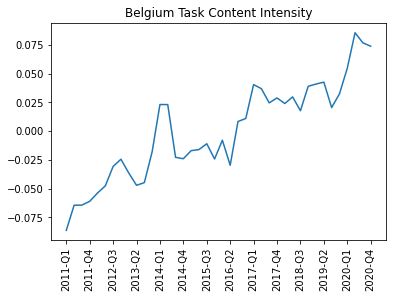

In [13]:
# Run for a country in countries list
country = 'Belgium'
combined_processed = standardise(combined_main, country)
combined_agg = intensity(combined_processed, country)